# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

3.7.1


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[: -predictions].copy()

In [8]:
m = Prophet()
m.fit(train_df);

/home/zark/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [15]:
future = m.make_future_dataframe(predictions)
forecast = m.predict(future)

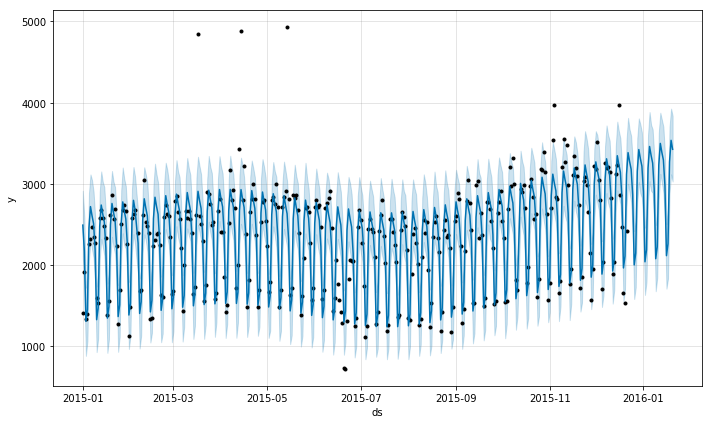

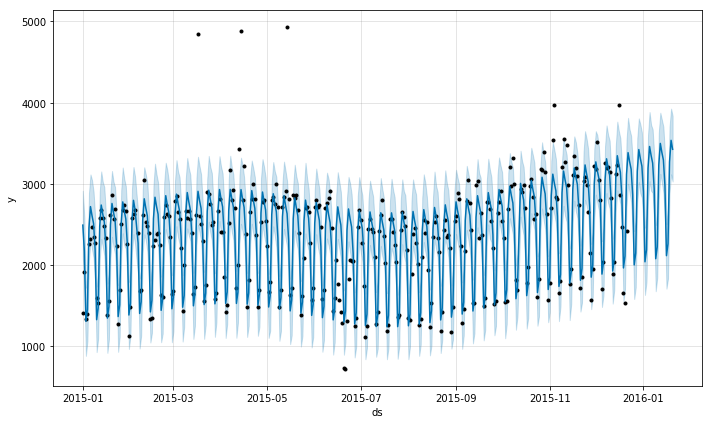

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
m.plot(forecast)

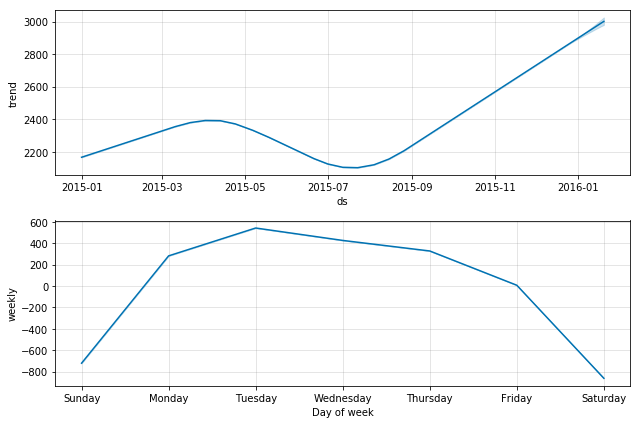

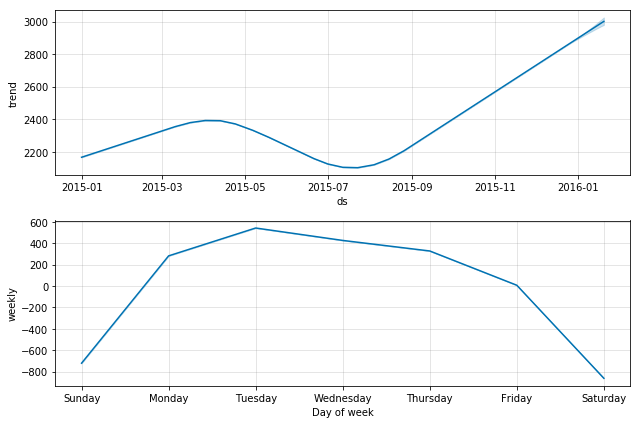

In [16]:
m.plot_components(forecast)

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [18]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [20]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(34.50086049906534, 599.795672524015)

In [22]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [23]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100 * cmp_df2['e'] / cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

/home/zark/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(35.05441244275765, 617.7964339602587)

## Предсказываем с помощью ARIMA

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [27]:
train_df = train_df.fillna(14).set_index('ds')

KeyError: 'ds'

Критерий Дики-Фуллера: p=0.107392


<Figure size 1152x720 with 0 Axes>

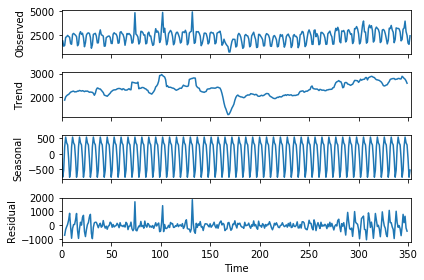

In [29]:
plt.figure(figsize=(16, 10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1]);

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?